# ベイジアンGLMM ランダムスロープモデル

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../data/processed/df_filtered_5years_exclude_too_far_islands.xlsx'
df = pd.read_excel(filepath)

df['population_change_rate'] = df.groupby('island_id')['population'].pct_change() * 100
df['log_income'] = np.log(df['income'])
df['log_area'] = np.log(df['area_km2'])
df['log_distance'] = np.log(df['distance_m'])
df = df.dropna(subset=['population_change_rate', 'dummy_after_bridge_opened', 'log_income'])

/tmp/ipykernel_10577/1446395779.py:4: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['population_change_rate'] = df.groupby('island_id')['population'].pct_change() * 100


In [12]:
y = df['population_change_rate']
bridge = df['dummy_after_bridge_opened']
income = df['log_income']
islands = dmatrix('C(island_id) -1', data=df, return_type='dataframe')
years = dmatrix('C(year) -1', data=df, return_type='dataframe')

n_obs = df.shape[0]
n_islands = islands.shape[1]
n_years = years.shape[1]

In [21]:
with pm.Model() as model:
    # Priors for fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=0, sigma=100)
    gamma_income = pm.Normal('gamma_income', mu=0, sigma=100)
    years_effects = pm.Normal('years_effects', mu=0, sigma=100, shape=n_years)
    sigma = pm.InverseGamma('sigma', alpha=0.001, beta=0.001)

    # Random effects for each island
    sd_islands = pm.HalfStudentT('sd_islands', nu=3, sigma=100)
    sd_bridge = pm.HalfStudentT('sd_beta_bridge', nu=3, sigma=100)
    islands_effects = pm.Normal('islands_effects', mu=0, sigma=sd_islands, shape=n_islands, dims='islands')

    # Random slopes for experience
    bridge_effects = pm.Normal('bridge_effects', mu=0, sigma=sd_bridge, shape=n_islands, dims='islands')

    # Link function
    # Non-centered parameterization of random effects
    mu = (
        intercept
        + islands_effects * islands
        + beta_bridge * bridge
        + gamma_income * income
        + pm.math.dot(years, years_effects)
        + bridge_effects * bridge
    )

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

pm.model_to_graphviz(model)

ValueError: Incompatible Elemwise input shapes [(549, 93), (1, 549)]

In [22]:
with model:
    idata = pm.sample(
        draws=8000,
        tune=3000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        target_accept=.95,
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


## アウトプットの保存

In [23]:
export_filepath = './sampling_hbm_random_slope.nc'
az.to_netcdf(idata, export_filepath)

'fixed_effects.nc'

## アウトプットのインポート

In [23]:
idata = az.from_netcdf('hbm_random_intercept.nc')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_bridge,7.905,5.665,-2.644,18.720,0.087,0.062,4231.0,8162.0,1.00
gamma[0],-0.831,0.796,-2.366,0.640,0.012,0.008,4425.0,8630.0,1.00
delta_island[0],1.215,15.688,-28.527,30.474,0.565,0.400,771.0,2139.0,1.01
delta_island[1],-3.657,12.298,-27.030,19.146,0.545,0.386,509.0,1522.0,1.01
delta_island[2],-0.799,12.514,-24.908,22.126,0.533,0.377,551.0,1646.0,1.01
...,...,...,...,...,...,...,...,...,...
delta_year[4],-3.327,11.925,-25.970,18.738,0.526,0.372,514.0,1466.0,1.01
delta_year[5],-7.656,11.950,-29.872,15.127,0.529,0.375,511.0,1536.0,1.01
delta_year[6],-9.623,11.932,-32.513,12.326,0.527,0.373,513.0,1527.0,1.01
delta_year[7],-12.390,11.905,-35.623,9.386,0.523,0.370,519.0,1490.0,1.01


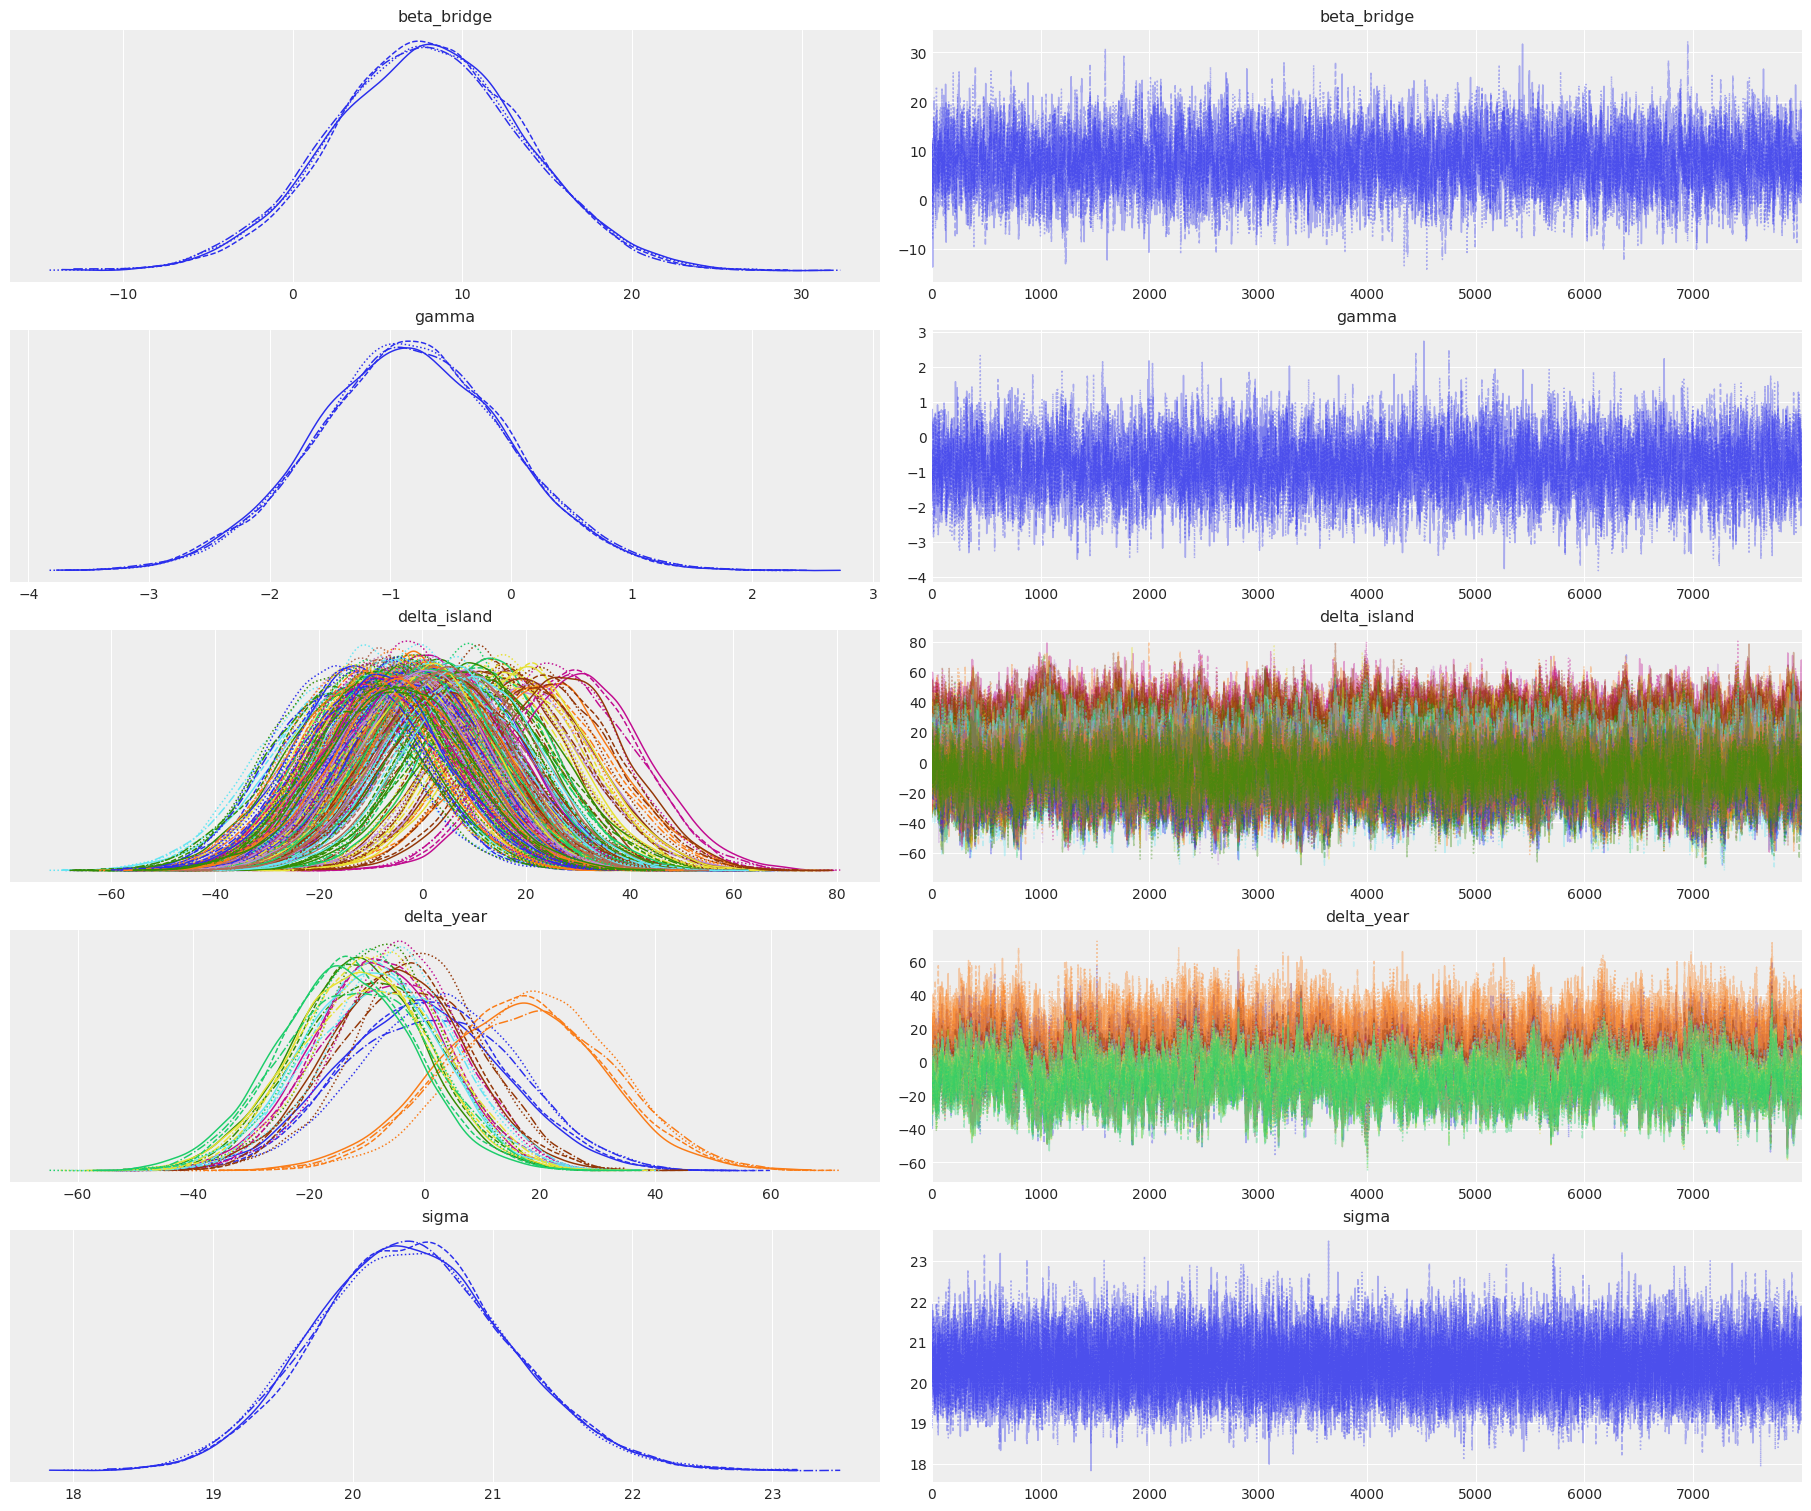

In [24]:
az.plot_trace(idata, figsize=(18, 15))  # サイズを調整
az.summary(idata)

In [29]:
az.summary(idata, var_names=['beta_bridge', 'gamma_income', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_bridge,8.091,5.584,-2.221,18.731,0.046,0.033,14467.0,20500.0,1.0
gamma_income,-0.812,0.805,-2.375,0.655,0.005,0.004,29574.0,26087.0,1.0
sigma,20.424,0.683,19.177,21.737,0.003,0.002,46010.0,24524.0,1.0


In [27]:
posterior_samples = idata.posterior

# 0以上のサンプルの割合を計算
prob_beta_bridge_positive = np.mean(posterior_samples['beta_bridge'] > 0)
print(f"Pr(beta_bridge > 0) = {prob_beta_bridge_positive:.4f}")
prob_beta_income_positive = np.mean(posterior_samples['gamma'] > 0)
print(f"Pr(gamma_income > 0) = {prob_beta_income_positive:.4f}")
prob_sigma_positive = np.mean(posterior_samples['sigma'] > 0)
print(f"Pr(sigma > 0) = {prob_sigma_positive:.4f}")

Pr(beta_bridge > 0) = 0.9205
Pr(gamma_income > 0) = 0.1450
Pr(sigma > 0) = 1.0000
